### Sekcja generowania danych historycznych

In [28]:
import random as rnd
import matplotlib.pyplot as plt

def errorify(value):
    error_factors = [0.01,0.1,10,100]
    error_value = value * rnd.choice(error_factors)
    return error_value

def error_price(price):
    return errorify(price)

def error_quantity(quantity):
    return errorify(quantity)

def gen_product(orders_no, price_init, price_end, order_qunat_rng, error_prob):
    price_curr = price_init
    price_increase = (price_end - price_init) / orders_no
    product_orders = []
    for i in range(orders_no):
        price = round(price_curr + (rnd.uniform(-3,3) * price_increase), 2)
        quantity = rnd.randrange(order_qunat_rng[0], order_qunat_rng[1])
        if rnd.random() < error_prob:
            if rnd.random() > 0.5:
                price = error_price(price)
            else:
                quantity = error_quantity(quantity)
        product_orders.append((price, quantity))
        price_curr += price_increase

    return product_orders

Przykładowe dane na podstawie treści zadania

[(99.32, 48), (101.58, 46), (101.15, 31), (101.67, 45), (101.58, 33), (103.19, 31), (102.43, 30), (101.67, 34), (102.23, 49), (104.67, 33), (104.02, 39), (105.0, 30), (104.14, 42), (105.36, 49), (106.01, 33), (106.76, 40), (106.29, 35), (107.72, 43), (107.73, 37), (107.98, 37), (107.46, 50), (107.6, 40), (108.45, 41), (108.1, 48), (110.29, 45), (110.04, 36), (110.38, 32), (110.57, 44), (110.67, 36), (111.09, 50), (112.14, 41), (111.87, 43), (112.52, 32), (112.85, 37), (112.82, 45), (112.97, 44), (11.462000000000002, 45), (115.64, 36), (116.05, 45), (116.67, 37), (115.47, 43), (115.75, 38), (117.98, 40), (11.605, 35), (1171.9, 36), (118.47, 48), (119.45, 49), (119.19, 41), (118.43, 32), (120.46, 0.43), (119.57, 44), (120.63, 31), (120.52, 35), (121.5, 49), (120.63, 33), (1223.7, 43), (123.09, 42), (123.44, 49), (124.34, 33), (122.83, 44)]


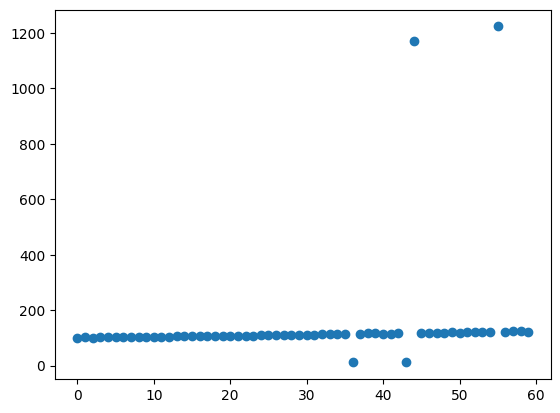

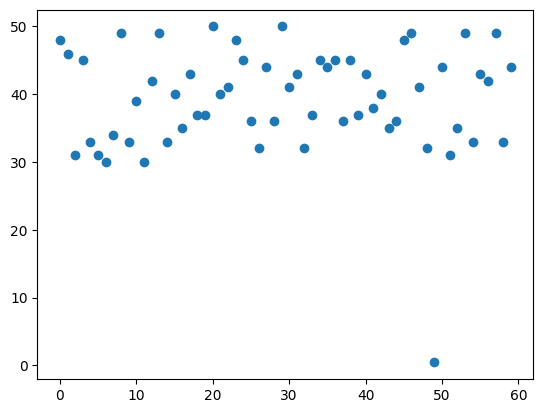

<Figure size 640x480 with 0 Axes>

In [29]:
product_sales = gen_product(60, 100, 124, (30,51), 0.1)
print(product_sales)
x = [x for x in range(60)]
y_price = [x[0] for x in product_sales]
y_quantity = [x[1] for x in product_sales]
plt.scatter(x, y_price)
plt.show()
plt.clf()
plt.scatter(x, y_quantity)
plt.show()
plt.clf()

### Zastosowanie regresji liniowej

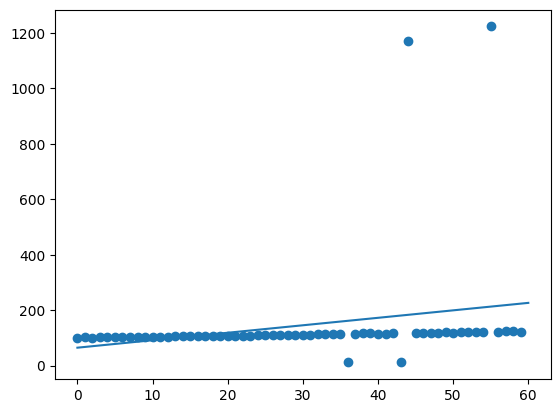

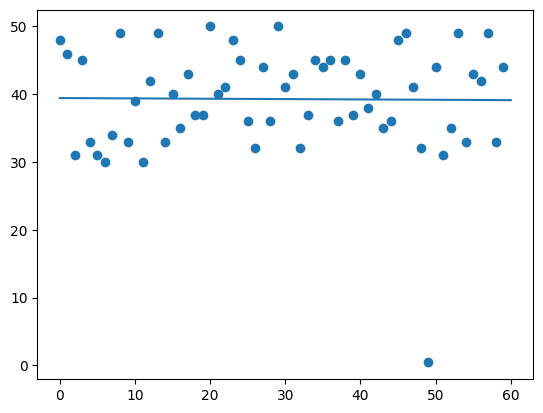

<Figure size 640x480 with 0 Axes>

In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression

x_np = np.array(x). reshape((-1,1))
y_price = np.array(y_price)
y_quantity = np.array(y_quantity)

model_price = LinearRegression().fit(x_np, y_price)
model_quantity = LinearRegression().fit(x_np, y_quantity)

price_coeffs = (model_price.coef_[0], model_price.intercept_)
quantity_coeffs = (model_quantity.coef_[0], model_quantity.intercept_)

plt.scatter(x, y_price)
plt.plot([0,60], [price_coeffs[1], 60 * price_coeffs[0] + price_coeffs[1]])
plt.show()
plt.clf()
plt.scatter(x, y_quantity)
plt.plot([0,60], [quantity_coeffs[1], 60 * quantity_coeffs[0] + quantity_coeffs[1]])
plt.show()
plt.clf()

Remove outliers

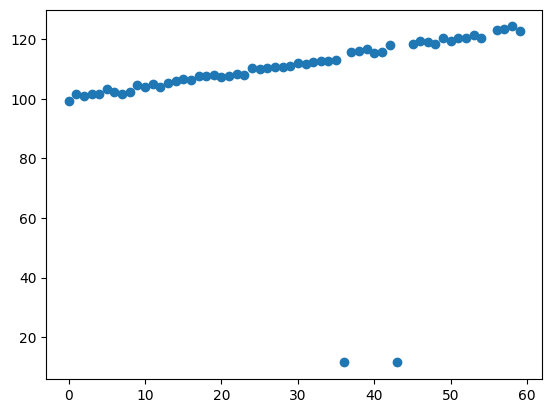

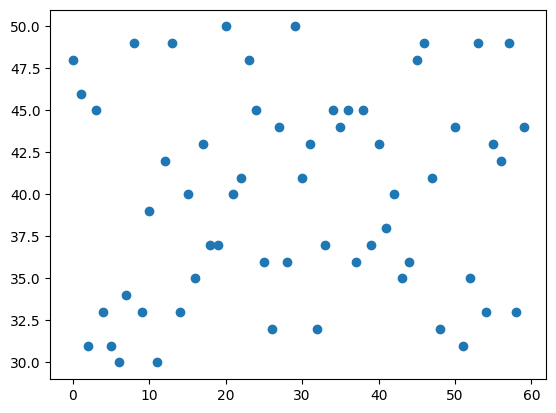

<Figure size 640x480 with 0 Axes>

In [31]:
y_price_exp = [(x * price_coeffs[0] + price_coeffs[1]) for x in x]
y_quantity_exp = [(x * quantity_coeffs[0] + quantity_coeffs[1]) for x in x]

SSE_price = 0
SSE_quantity = 0

for i in range(60):
    SSE_price += (y_price[i] - y_price_exp[i])**2
    SSE_quantity += (y_quantity[i] - y_quantity_exp[i])**2

import math
s_price = math.sqrt(SSE_price/60-2)
s_quantity = math.sqrt(SSE_quantity/60-2)

x_price = []
x_quantity = []
y_price_good = []
y_quantity_good = []

for i in range(60):
    if abs(y_price[i] - y_price_exp[i]) < abs(2 * s_price):
        x_price.append(i)
        y_price_good.append(y_price[i])
    if abs(y_quantity[i] - y_quantity_exp[i]) < abs(2 * s_quantity):
        x_quantity.append(i)
        y_quantity_good.append(y_quantity[i])

plt.scatter(x_price, y_price_good)
plt.show()
plt.clf()
plt.scatter(x_quantity, y_quantity_good)
plt.show()
plt.clf()